In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
from astropy.io import fits
import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table, vstack, hstack, join
import re
import warnings
from tqdm import tqdm

from astroquery.simbad import Simbad
from astroquery.nist import Nist
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier
from astroquery.mast import Observations

## Query MAST for all SWP data

In [3]:
MAST = Observations.query_criteria(obs_collection='IUE',
                                   instrument_name='SWP', 
                                   filters='LOW DISP',
                                   dataproduct_type='spectrum')

display(MAST.columns)
print('Results: ', len(MAST))


<TableColumns names=('dataproduct_type','calib_level','obs_collection','obs_id','target_name','s_ra','s_dec','t_min','t_max','t_exptime','wavelength_region','filters','em_min','em_max','target_classification','obs_title','t_obs_release','instrument_name','proposal_pi','proposal_id','proposal_type','project','sequence_number','provenance_name','s_region','jpegURL','dataURL','dataRights','mtFlag','srcDen','intentType','obsid','objID')>

Results:  35715


In [4]:
MAST#['obsid']

<Table masked=True length=35715>
dataproduct_type calib_level obs_collection  obs_id  target_name         s_ra            s_dec         t_min    ...                             dataURL                              dataRights mtFlag  srcDen intentType obsid  objID 
      str8          int64         str3        str8      str20          float64          float64       float64   ...                              str64                                  str6     bool  float64    str7     str6   str6 
---------------- ----------- -------------- -------- ------------ ------------------ -------------- ----------- ... ---------------------------------------------------------------- ---------- ------ ------- ---------- ------ ------
        spectrum           2            IUE swp00502   HH0540-407  85.83384495529998 -41.0321076132 47090.07736 ... http://archive.stsci.edu/pub/vospectra/iue2/swp00502mxlo_vo.fits     PUBLIC     --  5885.0    science 306260 533138
        spectrum           2            IUE swp00503  PG 1543+489 236.37416086100006  48.7689683624 47319.89071 ... http://archive.stsci.edu/pub/vospectra/iue2/swp00503mxlo_vo.fits     PUBLIC     --  5885.0    science 306261 533139
        spectrum           2            IUE swp00506        Z ORI  88.96242547610001  13.6950620438 48147.49345 ... http://archive.stsci.edu/pub/vospectra/iue2/swp00506mxlo_vo.fits     PUBLIC     --  5885.0    science 306262 533140
        spectrum           2            IUE swp00507     NGC 3783 174.75727498239996 -37.7384983469  48793.7366 ... http://archive.stsci.edu/pub/vospectra/iue2/swp00507mxlo_vo.fits     PUBLIC     --  5885.0    science 306263 533141
        spectrum           2            IUE swp00508     NGC 3783 174.75727498239996 -37.7384983469 48793.83549 ... http://archive.stsci.edu/pub/vospectra/iue2/swp00508mxlo_vo.fits     PUBLIC     --  5885.0    science 306264 533142
        spectrum           2            IUE swp00510     HD 95109 164.45129142719998 -59.7317804134 48048.15933 ... http://archive.stsci.edu/pub/vospectra/iue2/swp00510mxlo_vo.fits     PUBLIC     --  5885.0    science 306265 533143
        spectrum           2            IUE swp00511     0101-724      15.8077289286 -72.1537565501 49586.58238 ... http://archive.stsci.edu/pub/vospectra/iue2/swp00511mxlo_vo.fits     PUBLIC     --  5885.0    science 306266 533144
        spectrum           2            IUE swp01140     NGC 6826  296.1999682794001  50.5221814754 43581.36424 ... http://archive.stsci.edu/pub/vospectra/iue2/swp01140mxlo_vo.fits     PUBLIC     --  5885.0    science 306267 533145
        spectrum           2            IUE swp01141       SS CYG  325.6783079695999  43.5792560411  43581.4463 ... http://archive.stsci.edu/pub/vospectra/iue2/swp01141mxlo_vo.fits     PUBLIC     --  5885.0    science 306268 533146
        spectrum           2            IUE swp01198     HD 60753 113.36306761050002 -50.5843676263 43587.35803 ... http://archive.stsci.edu/pub/vospectra/iue2/swp01198mxlo_vo.fits     PUBLIC     --  5885.0    science 306269 533147
        spectrum           2            IUE swp01199     HD 60753 113.36306761050002 -50.5843676263   43587.375 ... http://archive.stsci.edu/pub/vospectra/iue2/swp01199mxlo_vo.fits     PUBLIC     --  5885.0    science 306270 533148
        spectrum           2            IUE swp01201     HD 60753     113.3630731431 -50.5838676386 43587.48542 ... http://archive.stsci.edu/pub/vospectra/iue2/swp01201mxlo_vo.fits     PUBLIC     --  5885.0    science 306271 533149
        spectrum           2            IUE swp01202       WAVCAL 113.36306761050002 -50.5843676263 43587.51806 ... http://archive.stsci.edu/pub/vospectra/iue2/swp01202mxlo_vo.fits     PUBLIC     --  5885.0    science 306272 533150
        spectrum           2            IUE swp01210     HD 38666  86.49809287210002 -32.3057673794 43589.22778 ... http://archive.stsci.edu/pub/vospectra/iue2/swp01210mxlo_vo.fits     PUBLIC     --  5885.0    science 306273 533151
        spectrum       

## xMatch MAST results with GALEX catalogue

In [5]:
MAST_GALEX = XMatch.query(cat1=MAST,
             cat2='vizier:II/335/galex_ais',
             max_distance=5 * u.arcsec, colRA1='s_ra', colDec1='s_dec')

## Remove rows where FUVmag column is masked
MAST_GALEX = MAST_GALEX[MAST_GALEX['FUVmag'].data.mask==False]

display(MAST_GALEX.columns)
print('Results: ', len(MAST_GALEX))

<TableColumns names=('angDist','dataproduct_type','calib_level','obs_collection','obs_id','target_name','s_ra','s_dec','t_min','t_max','t_exptime','wavelength_region','filters','em_min','em_max','target_classification','obs_title','t_obs_release','instrument_name','proposal_pi','proposal_id','proposal_type','project','sequence_number','provenance_name','s_region','jpegURL','dataURL','dataRights','mtFlag','srcDen','intentType','obsid','objID','RAJ2000','DEJ2000','name','objid','phID','Cat','RAfdeg','DEfdeg','FUVexp','NUVexp','GLON','GLAT','tile','img','sv','r.fov','Obs','b','E(B-V)','Sp?','chkf','FUVmag','e_FUVmag','NUVmag','e_NUVmag','FUV.a','e_FUV.a','NUV.a','e_NUV.a','FUV.4','e_FUV.4','NUV.4','e_NUV.4','FUV.6','e_FUV.6','NUV.6','e_NUV.6','Fafl','Nafl','Fexf','Nexf','Fflux','e_Fflux','Nflux','e_Nflux','FXpos','FYpos','NXpos','NYpos','Fima','Nima','Fr','Nr','nS/G','fS/G','nell','fell','nPA','e_nPA','fPA','e_fPA','Fnr','F3r','Nar','Narms','Nbrms','Far','Farms','Fbrms','w_NUV','w_FUV','P

Results:  4831


In [6]:
MAST_GALEX[MAST_GALEX['FUVmag'].data.mask==False]

<Table length=4831>
angDist  dataproduct_type calib_level obs_collection  obs_id  target_name        s_ra        ...   Gd    Nd        primidd                       groupidd                                grouptot                  OName      Size 
float64        str8          int64         str3        str8      str16         float64       ... int64 int64        int64                         str79                                   str79                    str31    float64
-------- ---------------- ----------- -------------- -------- ----------- ------------------ ... ----- ----- ------------------- --------------------------------------- --------------------------------------- ---------- -------
1.253244         spectrum           2            IUE swp54563   BD+1 4381  312.8392705808001 ...     0     1 6379430450845192192                     6379430450845192244                     6379430450845192244          N     0.0
2.108969         spectrum           2            IUE swp54564    LSIV-1 2     267.8621572034 ...     0     1 6375595346771313664                     6375595346771314140                     6375595346771314140          N     0.0
1.768695         spectrum           2            IUE swp54580       3C273 187.27753044840006 ...     0     1 6378937856751043584                     6378937856751043795                     6378937856751043795          N     0.0
1.768695         spectrum           2            IUE swp54581       3C273 187.27753044840006 ...     0     1 6378937856751043584                     6378937856751043795                     6378937856751043795          N     0.0
1.065146         spectrum           2            IUE swp54590        TPYX 136.17316650470002 ...     0     1 6382421128915192832                     6382421128915192998                     6382421128915192998          N     0.0
1.065146         spectrum           2            IUE swp54591        TPYX 136.17316650470002 ...     0     1 6382421128915192832                     6382421128915192998                     6382421128915192998          N     0.0
1.475047         spectrum           2            IUE swp54605     3C390.3     280.5365004345 ...     1     2 6372499146723560448 6372499146723560471+6372499142428591423 6372499146723560471+6372499142428591423          N     0.0
1.865393         spectrum           2            IUE swp54608 PG 0943+521 146.79875213950004 ...     1     2 6373765691776958464 6373765691776958560+6373765697145671349 6373765691776958560+6373765697145671349          N     0.0
1.253244         spectrum           2            IUE swp54611   BD+1 4381  312.8392705808001 ...     0     1 6379430450845192192                     6379430450845192244                     6379430450845192244          N     0.0
2.108969         spectrum           2            IUE swp54612   LV IV-1 2     267.8621572034 ...     0     1 6375595346771313664                     6375595346771314140                     6375595346771314140          N     0.0
0.530194         spectrum           2            IUE swp54632      AG DRA 240.42095125410003 ...     0     1 6371725002490776576                     6371725002490776126                     6371725002490776126          N     0.0
1.253244         spectrum           2            IUE swp54649   BD+1 4381  312.8392705808001 ...     0     1 6379430450845192192                     6379430450845192244                     6379430450845192244          N     0.0
2.108969         spectrum           2            IUE swp54650   LS IV-1 2     267.8621572034 ...     0     1 6375595346771313664                     6375595346771314140                     6375595346771314140          N     0.0
1.475047         spectrum           2            IUE swp54655     3C390.3     280.5365004345 ...     1     2 6372499146723560448 6372499146723560471+6372499142428591423 6372499146723560471+6372499142428591423          N     0.0
1.875304         spectrum           2            IUE swp54678   HD 157978 261.57911983400004 ...     0  

In [7]:
# test = XMatch.query(cat1='vizier:VI/110/inescat',
#                     cat2='vizier:II/335/galex_ais',
#                     max_distance=5 * u.arcsec)

## xMatch MAST + GALEX results with SIMBAD

In [8]:
MAST_GALEX_SIMBAD = XMatch.query(cat1=MAST_GALEX,
                    cat2='simbad',
                    max_distance=5 * u.arcsec, colRA1='s_ra', colDec1='s_dec')

display(MAST_GALEX_SIMBAD.columns)
print('Results: ', len(MAST_GALEX_SIMBAD))

<TableColumns names=('angDist_1','angDist_2','dataproduct_type','calib_level','obs_collection','obs_id','target_name','s_ra','s_dec','t_min','t_max','t_exptime','wavelength_region','filters','em_min','em_max','target_classification','obs_title','t_obs_release','instrument_name','proposal_pi','proposal_id','proposal_type','project','sequence_number','provenance_name','s_region','jpegURL','dataURL','dataRights','mtFlag','srcDen','intentType','obsid','objID','RAJ2000','DEJ2000','name','objid','phID','Cat','RAfdeg','DEfdeg','FUVexp','NUVexp','GLON','GLAT','tile','img','sv','r.fov','Obs','b','E(B-V)','Sp?','chkf','FUVmag','e_FUVmag','NUVmag','e_NUVmag','FUV.a','e_FUV.a','NUV.a','e_NUV.a','FUV.4','e_FUV.4','NUV.4','e_NUV.4','FUV.6','e_FUV.6','NUV.6','e_NUV.6','Fafl','Nafl','Fexf','Nexf','Fflux','e_Fflux','Nflux','e_Nflux','FXpos','FYpos','NXpos','NYpos','Fima','Nima','Fr','Nr','nS/G','fS/G','nell','fell','nPA','e_nPA','fPA','e_fPA','Fnr','F3r','Nar','Narms','Nbrms','Far','Farms','Fbrms','w_N

Results:  21751


In [9]:
## To view all votable fields (fields you can query Simbad with):
# Simbad.list_votable_fields()

## For a description of a specific field:
Simbad.get_field_description('coo_bibcode')

bibliographical reference


## Take stock of object types in sample

(-1.0, 67.0)

<Figure size 640x480 with 0 Axes>

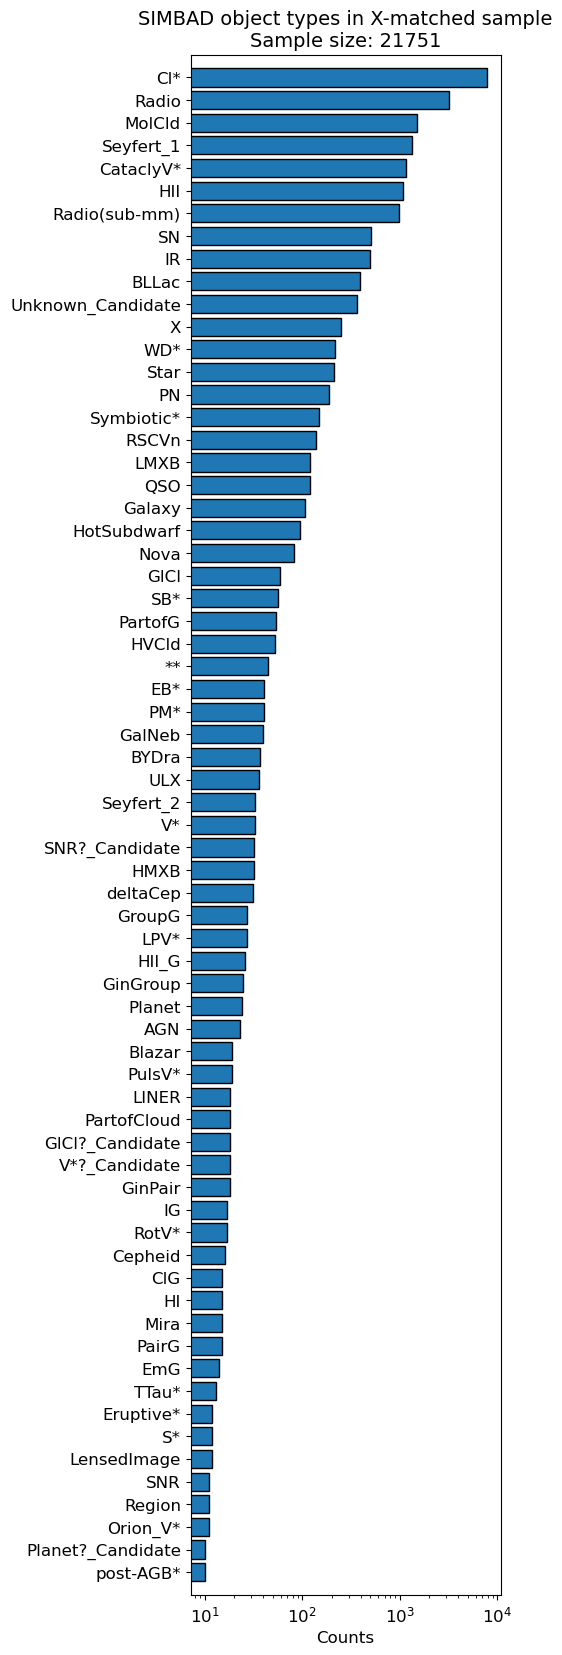

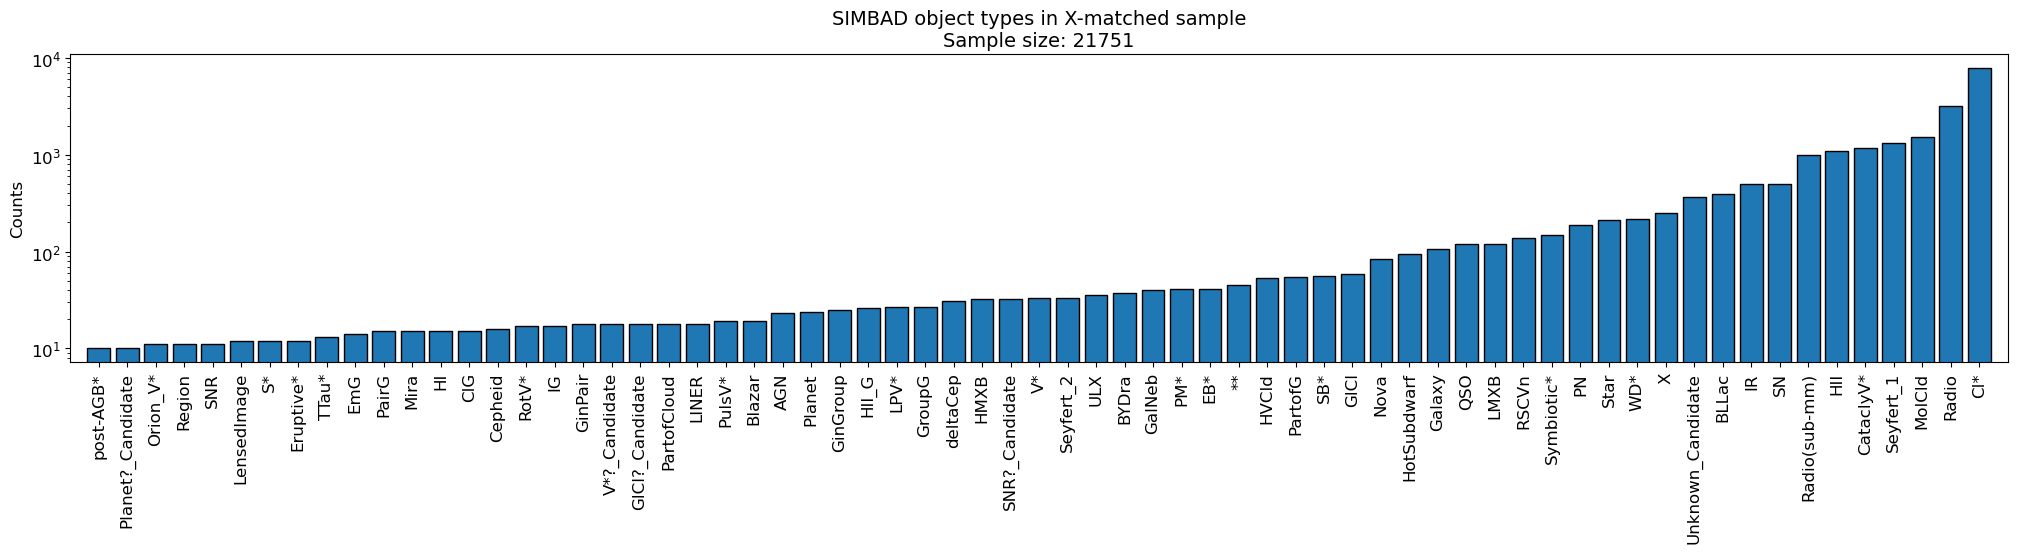

In [10]:
## Count occurence rates of object types in sample

cats = np.unique(MAST_GALEX_SIMBAD['main_type'])
counts = np.zeros(len(cats))

for i in range(len(cats)):
    counts[i] = np.sum( MAST_GALEX_SIMBAD['main_type'] == cats[i] )


## Ignore categories with <2 members, sort descending

cnt = counts >= 10
cats = cats[cnt]
counts = counts[cnt]

order = np.argsort(counts)
cats = cats[order]
counts = counts[order]

## Plot hbar

plt.tight_layout()

plt.figure(figsize=(4,20))
plt.barh(cats, counts, edgecolor='k')
plt.xlabel('Counts', fontsize=12, c='k');
plt.title(f'SIMBAD object types in X-matched sample\nSample size: {len(MAST_GALEX_SIMBAD)}', fontsize=14, c='k')

plt.xscale('log')
plt.yticks(fontsize=12, c='k');
plt.xticks(fontsize=12, c='k');
plt.ylim([-1, len(cats)])

## Plot vbar

plt.figure(figsize=(25, 4))
plt.bar(cats, counts, edgecolor='k')
plt.ylabel('Counts', fontsize=12, c='k');
plt.title(f'SIMBAD object types in X-matched sample\nSample size: {len(MAST_GALEX_SIMBAD)}', fontsize=14, c='k')

plt.yscale('log')
plt.yticks(fontsize=12, c='k');
plt.xticks(fontsize=12, c='k', rotation=90);
plt.xlim([-1, len(cats)])



### Make all-stars dataset

In [11]:
## Make temporary dataset and just cut out all the non-stars

nonstars = ['AGN',
            'Assoc*',
            'BClG',
            'BH_Candidate',
            'BLLac',
            'Blazar',
            'BlueCompG',
            'Cl*',
            'ClG',
            'ClG_Candidate',
            'Compact_Gr_G',
            'EmG',
            'EmObj',
            'G_Candidate',
            'GalNeb',
            'Galaxy',
            'GinCl',
            'GinGroup',
            'GinPair',
            'GlCl',
            'GlCl?_Candidate',
            'GravLensSystem',
            'GroupG',
            'HI',
            'HII',
            'HII_G',
            'HVCld',
            'IG',
            'IR',
            'LINER',
            'LensedImage',
            'LensedQ',
            'Maser',
            'MolCld',
            'NIR',
            'Nova',
            'PN',
            'PairG',
            'PartofCloud',
            'PartofG',
            'Planet',
            'Planet?_Candidate',
            'QSO',
            'Radio',
            'Radio(cm)',
            'Radio(mm)',
            'Radio(sub-mm)',
            'RadioG',
            'Region',
            'RfNeb',
            'SN',
            'SNR',
            'SNR?_Candidate',
            'Seyfert',
            'Seyfert_1',
            'Seyfert_2',
            'StarburstG',
            'Transient',
            'ULX',
            'ULX?_Candidate',
            'UV',
            'Unknown_Candidate',
            'X',
            'brownD*_Candidate']



## Drop objects of types matching nonstars

drop = [True]*len(MAST_GALEX_SIMBAD)

for otype in nonstars: 
    
    drop = np.logical_and( drop,  MAST_GALEX_SIMBAD['main_type']!=otype )
    
datastars = MAST_GALEX_SIMBAD[drop]

print(len(datastars), np.sum(drop))
display(datastars[:5])


2666 2666


<Table length=5>
angDist_1 angDist_2 dataproduct_type calib_level obs_collection  obs_id  target_name        s_ra            s_dec        t_min       t_max    ...    B       V       R       J       H       K       u       g       r       i       z   
 float64   float64        str8          int64         str3        str8      str15         float64          float64      float64     float64   ... float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64
--------- --------- ---------------- ----------- -------------- -------- ----------- ------------------ ------------- ----------- ----------- ... ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- -------
 1.333144  1.253244         spectrum           2            IUE swp54563   BD+1 4381  312.8392705808001  2.3128699146 49839.56022 49839.58104 ...    9.62    9.52      --    9.18   9.111   9.034      --      --      --      --      --
 1.463298  2.108969         spectrum           2            IUE swp54564    LSIV-1 2     267.8621572034 -1.7227608448 49839.66723 49839.78181 ...    11.4    10.9      --  10.094   9.993    9.91      --      --      --      --      --
 0.951411  1.065146         spectrum           2            IUE swp54590        TPYX 136.17316650470002 -32.379677557 49841.49174  49841.6202 ...      --      --      --  15.149  14.962  14.684      --      --      --      --      --
 0.951411  1.065146         spectrum           2            IUE swp54591        TPYX 136.17316650470002 -32.379677557 49841.64644 49841.78184 ...      --      --      --  15.149  14.962  14.684      --      --      --      --      --
 2.268267  1.865393         spectrum           2            IUE swp54608 PG 0943+521 146.79875213950004 51.9023648065 49843.25677 49843.27065 ...   14.03   13.91  14.909  13.606  13.454  13.495  14.399  13.779  13.799  14.545  14.129

## Filter results to non-exotic objects and FGK dwarfs

In [12]:
# for i in range(len(np.unique(MAST_GALEX_SIMBAD['main_type']))):

#     typ = np.unique(MAST_GALEX_SIMBAD['main_type'])[i]
#     ex = MAST_GALEX_SIMBAD[MAST_GALEX_SIMBAD['main_type']==typ][0]['main_id']
#     cnt = np.sum( MAST_GALEX_SIMBAD['main_type'] == typ )
#     print(ex)

typ = np.unique(MAST_GALEX_SIMBAD['main_type'])[11]
ex = MAST_GALEX_SIMBAD[MAST_GALEX_SIMBAD['main_type']==typ][5]['main_id']
cnt = np.sum( MAST_GALEX_SIMBAD['main_type'] == typ )
print(typ, ex, cnt)

C* V* X Cnc 7


### Limit to FGK spectral types

In [13]:
sptypes = np.array(['F', 'G', 'K'])
index = [False]*len(MAST_GALEX_SIMBAD)

for i, spt in enumerate(MAST_GALEX_SIMBAD['sp_type']):
    
    if spt.data==0:
        print('No sptype', spt, spt.data, MAST_GALEX_SIMBAD[i]['main_id'])
        continue
    
    isFGK = False
    
    for s in sptypes:
        isFGK = np.logical_or(isFGK, np.any(np.isin([*spt], s)))
        
    if isFGK:
        index[i] = True
        
data_FGK = MAST_GALEX_SIMBAD[index]

print(np.sum(index))
display( data_FGK[:5] )

No sptype -- 0.0 [DAC2007] C23
No sptype -- 0.0 [DAC2007] C8
No sptype -- 0.0 [ZBF2017] arp298  HII 18
No sptype -- 0.0 [DAC2007] C28
No sptype -- 0.0 [DAC2007] C15
No sptype -- 0.0 [DAC2007] C18
No sptype -- 0.0 [DAC2007] C7
No sptype -- 0.0 [DAC2007] C29
No sptype -- 0.0 [ZBF2017] arp298 MC  4
No sptype -- 0.0 [DAC2007] C20
No sptype -- 0.0 [RLA2011] E
No sptype -- 0.0 [INI2020] D
No sptype -- 0.0 [ZBF2017] arp298  HII 12
No sptype -- 0.0 [DAC2007] C26
No sptype -- 0.0 [DAC2007] C12
No sptype -- 0.0 [ZBF2017] arp298 MC  8
No sptype -- 0.0 [DAC2007] C22
No sptype -- 0.0 [ZBF2017] arp298 MC  5
No sptype -- 0.0 [DAC2007] C17
No sptype -- 0.0 [DAC2007] C3
No sptype -- 0.0 [DAC2007] C27
No sptype -- 0.0 [BPM2002] NGC 7469 C
No sptype -- 0.0 [DAC2007] C19
No sptype -- 0.0 [DAC2007] C21
No sptype -- 0.0 [DAC2007] C11
No sptype -- 0.0 [ZBF2017] arp298 MC  6
No sptype -- 0.0 [DAC2007] C16
No sptype -- 0.0 [ZBF2017] arp298 MC  9
No sptype -- 0.0 [DAC2007] C24
No sptype -- 0.0 [DAC2007] C25
No 

No sptype -- 0.0 [DAC2007] C21
No sptype -- 0.0 [DAC2007] C11
No sptype -- 0.0 [ZBF2017] arp298 MC  6
No sptype -- 0.0 [DAC2007] C16
No sptype -- 0.0 [ZBF2017] arp298 MC  9
No sptype -- 0.0 [DAC2007] C24
No sptype -- 0.0 [DAC2007] C25
No sptype -- 0.0 [DAC2007] C5
No sptype -- 0.0 [DAC2007] C9
No sptype -- 0.0 [DAC2007] C10
No sptype -- 0.0 [INI2020] A
No sptype -- 0.0 [DAC2007] C14
No sptype -- 0.0 EQ J2303+0852
No sptype -- 0.0 [DAC2007] C13
No sptype -- 0.0 [DAC2007] C30
No sptype -- 0.0 [ZBF2017] arp298 MC  1
No sptype -- 0.0 [BPM2002] NGC 7469 B
No sptype -- 0.0 [DAC2007] C2
No sptype -- 0.0 [RLA2011] A
No sptype -- 0.0 NGC  7469
No sptype -- 0.0 [BPM2002] NGC 7469 A
No sptype -- 0.0 [DAC2007] C1
No sptype -- 0.0 [INI2020] B
No sptype -- 0.0 [ZBF2017] arp298  HII  4
No sptype -- 0.0 [ZBF2017] arp298  HII 10
No sptype -- 0.0 [DAC2007] C6
No sptype -- 0.0 [LLS2003] NGC 7469 A
No sptype -- 0.0 [LLS2003] NGC 7469 B
No sptype -- 0.0 [LLS2003] NGC 7469 C
No sptype -- 0.0 [INI2020] C
No 

No sptype -- 0.0 [DAC2007] C7
No sptype -- 0.0 [DAC2007] C29
No sptype -- 0.0 [ZBF2017] arp298 MC  4
No sptype -- 0.0 [DAC2007] C20
No sptype -- 0.0 [RLA2011] E
No sptype -- 0.0 [INI2020] D
No sptype -- 0.0 [ZBF2017] arp298  HII 12
No sptype -- 0.0 [DAC2007] C26
No sptype -- 0.0 [DAC2007] C12
No sptype -- 0.0 [ZBF2017] arp298 MC  8
No sptype -- 0.0 [DAC2007] C22
No sptype -- 0.0 [ZBF2017] arp298 MC  5
No sptype -- 0.0 [DAC2007] C17
No sptype -- 0.0 [DAC2007] C3
No sptype -- 0.0 [DAC2007] C27
No sptype -- 0.0 [BPM2002] NGC 7469 C
No sptype -- 0.0 [DAC2007] C19
No sptype -- 0.0 [DAC2007] C21
No sptype -- 0.0 [DAC2007] C11
No sptype -- 0.0 [ZBF2017] arp298 MC  6
No sptype -- 0.0 [DAC2007] C16
No sptype -- 0.0 [ZBF2017] arp298 MC  9
No sptype -- 0.0 [DAC2007] C24
No sptype -- 0.0 [DAC2007] C25
No sptype -- 0.0 [DAC2007] C5
No sptype -- 0.0 [DAC2007] C9
No sptype -- 0.0 [DAC2007] C10
No sptype -- 0.0 [INI2020] A
No sptype -- 0.0 [DAC2007] C14
No sptype -- 0.0 EQ J2303+0852
No sptype -- 0.0 

No sptype -- 0.0 [DAC2007] C12
No sptype -- 0.0 [ZBF2017] arp298 MC  8
No sptype -- 0.0 [DAC2007] C22
No sptype -- 0.0 [ZBF2017] arp298 MC  5
No sptype -- 0.0 [DAC2007] C17
No sptype -- 0.0 [DAC2007] C3
No sptype -- 0.0 [DAC2007] C27
No sptype -- 0.0 [BPM2002] NGC 7469 C
No sptype -- 0.0 [DAC2007] C19
No sptype -- 0.0 [DAC2007] C21
No sptype -- 0.0 [DAC2007] C11
No sptype -- 0.0 [ZBF2017] arp298 MC  6
No sptype -- 0.0 [DAC2007] C16
No sptype -- 0.0 [ZBF2017] arp298 MC  9
No sptype -- 0.0 [DAC2007] C24
No sptype -- 0.0 [DAC2007] C25
No sptype -- 0.0 [DAC2007] C5
No sptype -- 0.0 [DAC2007] C9
No sptype -- 0.0 [DAC2007] C10
No sptype -- 0.0 [INI2020] A
No sptype -- 0.0 [DAC2007] C14
No sptype -- 0.0 EQ J2303+0852
No sptype -- 0.0 [DAC2007] C13
No sptype -- 0.0 [DAC2007] C30
No sptype -- 0.0 [ZBF2017] arp298 MC  1
No sptype -- 0.0 [BPM2002] NGC 7469 B
No sptype -- 0.0 [DAC2007] C2
No sptype -- 0.0 [RLA2011] A
No sptype -- 0.0 NGC  7469
No sptype -- 0.0 [BPM2002] NGC 7469 A
No sptype -- 0.0

No sptype -- 0.0 [DAC2007] C9
No sptype -- 0.0 [DAC2007] C10
No sptype -- 0.0 [INI2020] A
No sptype -- 0.0 [DAC2007] C2
No sptype -- 0.0 [DAC2007] C24
No sptype -- 0.0 [DAC2007] C5
No sptype -- 0.0 [ZBF2017] arp298  HII 12
No sptype -- 0.0 [DAC2007] C14
No sptype -- 0.0 [DAC2007] C8
No sptype -- 0.0 [DAC2007] C25
No sptype -- 0.0 [ZBF2017] arp298 MC  1
No sptype -- 0.0 [DAC2007] C13
No sptype -- 0.0 [ZBF2017] arp298 MC  9
No sptype -- 0.0 [DAC2007] C28
No sptype -- 0.0 [DAC2007] C30
No sptype -- 0.0 [INI2020] D
No sptype -- 0.0 [ZBF2017] arp298 MC  5
No sptype -- 0.0 [DAC2007] C1
No sptype -- 0.0 [BPM2002] NGC 7469 C
No sptype -- 0.0 [DAC2007] C6
No sptype -- 0.0 [RLA2011] A
No sptype -- 0.0 NGC  7469
No sptype -- 0.0 [DAC2007] C29
No sptype -- 0.0 [ZBF2017] arp298  HII 18
No sptype -- 0.0 [DAC2007] C20
No sptype -- 0.0 [DAC2007] C3
No sptype -- 0.0 [DAC2007] C23
No sptype -- 0.0 [ZBF2017] arp298 MC  4
No sptype -- 0.0 [DAC2007] C4
No sptype -- 0.0 [DAC2007] C26
No sptype -- 0.0 [DAC20

No sptype -- 0.0 [OCC2002] AG Dra N2
No sptype -- 0.0 [OCC2002] AG Dra N
No sptype -- 0.0 2MASX J08382309+6507160
No sptype -- 0.0 2XMM J135315.8+634546
No sptype -- 0.0 NGC  1705
No sptype -- 0.0 [TSK2008] 934
No sptype -- 0.0 NAME NGC 1705 CL* A
No sptype -- 0.0 [JSE87] 1928+738 2
No sptype -- 0.0 4C 73.18
No sptype -- 0.0 LEDA   38224
No sptype -- 0.0 Ton  1530
No sptype -- 0.0 ESO 113-45
No sptype -- 0.0 ESO 113-45
No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 Mrk 1148
No sptype -- 0.0 NGC  7603
No sptype -- 0.0 Mrk  542
No sptype -- 0.0 MCG+00-03-018
No sptype -- 0.0 NGC   622
No sptype -- 0.0 Mrk 1014
No sptype -- 0.0 LEDA   50824
No sptype -- 0.0 ESO 113-45
No sptype -- 0.0 NVSS J110647+723410
No sptype -- 0.0 [MWP92] B
No sptype -- 0.0 [MWP92] C
No sptype -- 0.0 NGC  3516
No sptype -- 0.0 [MWP92] A
No sptype -- 0.0 CXOU J110648.1+723412
No sptype -- 0.0 QSO B2005-489
No sptype -- 0.0 V* BY Cam
No sptype -- 0.0 V* BY Cam
No sptype -- 0.0 V* BY Cam

No sptype -- 0.0 NGC  5548
No sptype -- 0.0 NGC  5548
No sptype -- 0.0 NGC  5548
No sptype -- 0.0 LEDA   13065
No sptype -- 0.0 NGC  5548
No sptype -- 0.0 QSO B0323+022
No sptype -- 0.0 [D81b] 3C 390.3 C
No sptype -- 0.0 ICRF J184208.9+794617
No sptype -- 0.0 V* RR Pic
No sptype -- 0.0 IRAS 07598+6508
No sptype -- 0.0 NVSS J080430+645953
No sptype -- 0.0 V* RX And
No sptype -- 0.0 V* LS Peg
No sptype -- 0.0 V* LS Peg
No sptype -- 0.0 V* RX And
No sptype -- 0.0 V* RX And
No sptype -- 0.0 [MWP92] A
No sptype -- 0.0 NGC  3516
No sptype -- 0.0 NVSS J110647+723410
No sptype -- 0.0 [MWP92] C
No sptype -- 0.0 [MWP92] B
No sptype -- 0.0 [MWP92] A
No sptype -- 0.0 NGC  3516
No sptype -- 0.0 NVSS J110647+723410
No sptype -- 0.0 [MWP92] C
No sptype -- 0.0 [MWP92] B
No sptype -- 0.0 [MWP92] A
No sptype -- 0.0 NGC  3516
No sptype -- 0.0 NVSS J110647+723410
No sptype -- 0.0 [MWP92] C
No sptype -- 0.0 [MWP92] B
No sptype -- 0.0 NGC  3516
No sptype -- 0.0 [MWP92] A
No sptype -- 0.0 [MWP92] B
No sptype

No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 Mrk 1298
No sptype -- 0.0 [D81b] 3C 390.3 C
No sptype -- 0.0 ICRF J184208.9+794617
No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 2MASS J11243917+4201450
No sptype -- 0.0 LEDA   37161
No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 3C 273
No sptype -- 0.0 [CME2001] 3C 273  1
No sptype -- 0.0 NAME Vela Ring Galaxy
No sptype -- 0.0 [MWP92] A
No sptype -- 0.0 NGC  3516
No sptype -- 0.0 [MWP92] B
No sptype -- 0.0 NVSS J110647+723410
No sptype -- 0.0 [MWP92] A
No sptype -- 0.0 NGC  3516
No sptype -- 0.0 [MWP92] B
No sptype -- 0.0 NVSS J110647+723410
No sp

<Table length=5>
angDist_1 angDist_2 dataproduct_type calib_level obs_collection  obs_id  target_name        s_ra            s_dec        t_min       t_max    ...    B       V       R       J       H       K       u       g       r       i       z   
 float64   float64        str8          int64         str3        str8      str15         float64          float64      float64     float64   ... float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64
--------- --------- ---------------- ----------- -------------- -------- ----------- ------------------ ------------- ----------- ----------- ... ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- -------
 1.333144  1.253244         spectrum           2            IUE swp54563   BD+1 4381  312.8392705808001  2.3128699146 49839.56022 49839.58104 ...    9.62    9.52      --    9.18   9.111   9.034      --      --      --      --      --
 1.333144  1.253244         spectrum           2            IUE swp54611   BD+1 4381  312.8392705808001  2.3128699146  49843.5605 49843.58132 ...    9.62    9.52      --    9.18   9.111   9.034      --      --      --      --      --
 0.724534  0.530194         spectrum           2            IUE swp54632      AG DRA 240.42095125410003 66.8030147792 49845.51729 49845.51937 ...   11.06    9.74    8.52   7.154   6.365   6.209      --      --      --      --      --
 1.333144  1.253244         spectrum           2            IUE swp54649   BD+1 4381  312.8392705808001  2.3128699146 49847.55291 49847.57373 ...    9.62    9.52      --    9.18   9.111   9.034      --      --      --      --      --
 0.897053  1.875304         spectrum           2            IUE swp54678   HD 157978 261.57911983400004  7.5958788416 49852.34081 49852.34185 ...    6.64    6.04    5.43    4.56    4.06    3.97      --      --      --      --      --

### Limit to non-exotic objects

In [14]:
## Identify which object types to drop 
## (https://docs.google.com/spreadsheets/d/1CKYsmKPpbwsgG8Z2DPdURcD6u4HqbtA5ysGset5LhvU/edit#gid=0)

drop_types = ['**',
            'AGN',
            'Ae*',
            'Assoc*',
            'BClG',
            'BH_Candidate',
            'BLLac',
            'BYDra',
            'Blazar',
            'BlueCompG',
            'C*',
            'CataclyV*',
            'Cepheid',
            'Cl*',
            'ClG',
            'ClG_Candidate',
            'Compact_Gr_G',
            'EB*',
            'EmG',
            'EmObj',
            'Erupt*RCrB',
            'Eruptive*',
            'G_Candidate',
            'GalNeb',
            'Galaxy',
            'GinCl',
            'GinGroup',
            'GinPair',
            'GlCl',
            'GlCl?_Candidate',
            'GravLensSystem',
            'GroupG',
            'HI',
            'HII',
            'HII_G',
            'HMXB',
            'HVCld',
            'HotSubdwarf',
            'Hsd_Candidate',
            'IG',
            'IR',
            'LINER',
            'LMXB',
            'LensedImage',
            'LensedQ',
            'Maser',
            'Mira',
            'MolCld',
            'NIR',
            'Nova',
            'Orion_V*',
            'PN',
            'PairG',
            'PartofCloud',
            'PartofG',
            'Pec*',
            'Planet',
            'Planet?_Candidate',
            'PulsV*',
            'PulsV*WVir',
            'PulsV*bCep',
            'PulsV*delSct',
            'Pulsar',
            'QSO',
            'RRLyr',
            'RSCVn',
            'Radio',
            'Radio(cm)',
            'Radio(mm)',
            'Radio(sub-mm)',
            'RadioG',
            'Region',
            'RfNeb',
            'RotV*',
            'RotV*alf2CVn',
            'SB*',
            'SN',
            'SNR',
            'SNR?_Candidate',
            'Seyfert',
            'Seyfert_1',
            'Seyfert_2',
            'StarburstG',
            'Symbiotic*',
            'Transient',
            'ULX',
            'ULX?_Candidate',
            'UV',
            'Unknown_Candidate',
            'V*',
            'V*?_Candidate',
            'WD*',
            'WD*_Candidate',
            'WR*',
            'X',
            'XB',
            'YSO_Candidate',
            'brownD*_Candidate',
            'deltaCep',
            'gammaDor',
            'pulsV*S']

In [15]:
## Drop objects of types matching drop_types

drop = [True]*len(data_FGK)

for otype in drop_types: 
    
    drop = np.logical_and( drop,  data_FGK['main_type']!=otype )
    
data_FGK_normaltypes = data_FGK[drop]

print(len(data_FGK_normaltypes), np.sum(drop))
display(data_FGK_normaltypes[:5])


113 113


<Table length=5>
angDist_1 angDist_2 dataproduct_type calib_level obs_collection  obs_id  target_name        s_ra            s_dec         t_min       t_max    ...    B       V       R       J       H       K       u       g       r       i       z   
 float64   float64        str8          int64         str3        str8      str15         float64          float64       float64     float64   ... float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64
--------- --------- ---------------- ----------- -------------- -------- ----------- ------------------ -------------- ----------- ----------- ... ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- -------
 0.854251  1.326744         spectrum           2            IUE swp54894    HD199951     315.3224724693 -32.2577449364 49875.41707 49875.45873 ...   5.529   4.654      --    3.15   2.713   2.596      --      --      --      --      --
 0.993032  0.622868         spectrum           2            IUE swp55292     HD 2454  7.083429661399975  10.1900690724 49914.07061 49914.09145 ...    6.47      --     5.8   5.201   5.057   4.942      --      --      --      --      --
 0.205707   1.80418         spectrum           2            IUE swp55297   HD 131530 223.59536528340004 -11.8983649295 49914.87583 49914.92235 ...   6.768   5.788      --   4.231   3.635   3.608      --      --      --      --      --
 0.205707   1.80418         spectrum           2            IUE swp55367   HD 131530 223.59536528340004 -11.8983649295 49926.13388 49926.24638 ...   6.768   5.788      --   4.231   3.635   3.608      --      --      --      --      --
 1.901509  2.121468         spectrum           2            IUE swp55450     3C390.3     281.0995698355   79.729552485 49938.29668 49938.47722 ...    10.2    9.59      --   8.318    7.98   7.942      --      --      --      --      --

## Ask SIMBAD for more information

In [16]:
## To view all votable fields (fields you can query Simbad with):
# Simbad.list_votable_fields()

## For a description of a specific field:
Simbad.get_field_description('velocity')

all fields related with radial velocity and redshift


### FGK and non-exotic stars

In [17]:
warnings.filterwarnings('ignore')

## Set fields to query from Simbad
fields = ['typed_id', 'fe_h', 'velocity',
          'fluxdata(B)','fluxdata(V)','fluxdata(R)','fluxdata(I)','fluxdata(J)', 'fluxdata(K)', 
          'rot', 'sptype', 'otype', 'td1', 'ubv', 'v*', 'parallax', 'distance']

customSimbad = Simbad()

for f in fields: 
    customSimbad.add_votable_fields(f)


## Create first row of results table
# matchTable = Table.from_pandas(match)
r = customSimbad.query_object(data_FGK_normaltypes['main_id'][0])
dataresults = hstack([data_FGK_normaltypes[0], r])


## Iterate through all rows in match, query each object and add combined data to results
    
for i, obj in enumerate(tqdm(data_FGK_normaltypes['main_id'])):
    
    ## Skip first row, already included
    if i==0:
        continue
    
    ## Ask Simbad for information
    simbadqry = customSimbad.query_object(obj)
    
    ## Make a new row with XMatch + Simbad info for the object
    newrow = hstack([data_FGK_normaltypes[i], simbadqry])
    
    ## Add new row to results table
    dataresults = vstack([dataresults, newrow])
    
display(dataresults.columns)
display(dataresults[:5])
    

# ## Drop rows where SIMBAD doesn't give any spectral type
# results = results[results['sp_type'] != '']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:20<00:00,  5.50it/s]


<TableColumns names=('angDist_1','angDist_2','dataproduct_type','calib_level','obs_collection','obs_id','target_name','s_ra','s_dec','t_min','t_max','t_exptime','wavelength_region','filters','em_min','em_max','target_classification','obs_title','t_obs_release','instrument_name','proposal_pi','proposal_id','proposal_type','project','sequence_number','provenance_name','s_region','jpegURL','dataURL','dataRights','mtFlag','srcDen','intentType','obsid','objID','RAJ2000','DEJ2000','name','objid','phID','Cat','RAfdeg','DEfdeg','FUVexp','NUVexp','GLON','GLAT','tile','img','sv','r.fov','Obs','b','E(B-V)','Sp?','chkf','FUVmag','e_FUVmag','NUVmag','e_NUVmag','FUV.a','e_FUV.a','NUV.a','e_NUV.a','FUV.4','e_FUV.4','NUV.4','e_NUV.4','FUV.6','e_FUV.6','NUV.6','e_NUV.6','Fafl','Nafl','Fexf','Nexf','Fflux','e_Fflux','Nflux','e_Nflux','FXpos','FYpos','NXpos','NYpos','Fima','Nima','Fr','Nr','nS/G','fS/G','nell','fell','nPA','e_nPA','fPA','e_fPA','Fnr','F3r','Nar','Narms','Nbrms','Far','Farms','Fbrms','w_N

<Table length=5>
angDist_1 angDist_2 dataproduct_type calib_level obs_collection  obs_id  target_name        s_ra        ... Distance_distance Distance_Q Distance_unit Distance_merr Distance_perr Distance_method   Distance_bibcode  SCRIPT_NUMBER_ID
                                                                                                        ...                                                                                                                            
 float64   float64        str8          int64         str3        str8      str15         float64       ...      float64         str1         str4        float64       float64          str8             str19             int32      
--------- --------- ---------------- ----------- -------------- -------- ----------- ------------------ ... ----------------- ---------- ------------- ------------- ------------- --------------- ------------------- ----------------
 0.854251  1.326744         spectrum           2            IUE swp54894    HD199951     315.3224724693 ...           68.2929                       pc       -2.3161        2.3161           paral 2018yCat.1345....0G                1
 0.993032  0.622868         spectrum           2            IUE swp55292     HD 2454  7.083429661399975 ...           38.0910                       pc       -0.0827        0.0827           paral 2020yCat.1350....0G                1
 0.205707   1.80418         spectrum           2            IUE swp55297   HD 131530 223.59536528340004 ...          101.3480                       pc       -0.5783        0.5783           paral 2020yCat.1350....0G                1
 0.205707   1.80418         spectrum           2            IUE swp55367   HD 131530 223.59536528340004 ...          101.3480                       pc       -0.5783        0.5783           paral 2020yCat.1350....0G                1
 1.901509  2.121468         spectrum           2            IUE swp55450     3C390.3     281.0995698355 ...          136.7450                       pc       -0.1907        0.1907           paral 2020yCat.1350....0G                1

### FGK including exotic stars

In [18]:
warnings.filterwarnings('ignore')

## Set fields to query from Simbad
fields = ['typed_id', 'fe_h', 
          'flux(B)data','fluxdata(V)','fluxdata(R)','fluxdata(I)','fluxdata(J)', 'fluxdata(K)', 
          'rot', 'sptype', 'otype', 'td1', 'ubv', 'v*', 'parallax', 'distance']

customSimbad = Simbad()

for f in fields: 
    customSimbad.add_votable_fields(f)


## Create first row of results table
# matchTable = Table.from_pandas(match)
r = customSimbad.query_object(data_FGK['main_id'][0])
dataFGKresults = hstack([data_FGK[0], r])


## Iterate through all rows in match, query each object and add combined data to results
    
for i, obj in enumerate(tqdm(data_FGK['main_id'])):
    
    ## Skip first row, already included
    if i==0:
        continue
    
    ## Ask Simbad for information
    simbadqry = customSimbad.query_object(obj)
    
    ## Make a new row with XMatch + Simbad info for the object
    newrow = hstack([data_FGK[i], simbadqry])
    
    ## Add new row to results table
    dataFGKresults = vstack([dataFGKresults, newrow])
    
display(dataFGKresults.columns)
display(dataFGKresults[:5])
    

# ## Drop rows where SIMBAD doesn't give any spectral type
# results = results[results['sp_type'] != '']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 706/706 [02:16<00:00,  5.16it/s]


<TableColumns names=('angDist_1','angDist_2','dataproduct_type','calib_level','obs_collection','obs_id','target_name','s_ra','s_dec','t_min','t_max','t_exptime','wavelength_region','filters','em_min','em_max','target_classification','obs_title','t_obs_release','instrument_name','proposal_pi','proposal_id','proposal_type','project','sequence_number','provenance_name','s_region','jpegURL','dataURL','dataRights','mtFlag','srcDen','intentType','obsid','objID','RAJ2000','DEJ2000','name','objid','phID','Cat','RAfdeg','DEfdeg','FUVexp','NUVexp','GLON','GLAT','tile','img','sv','r.fov','Obs','b','E(B-V)','Sp?','chkf','FUVmag','e_FUVmag','NUVmag','e_NUVmag','FUV.a','e_FUV.a','NUV.a','e_NUV.a','FUV.4','e_FUV.4','NUV.4','e_NUV.4','FUV.6','e_FUV.6','NUV.6','e_NUV.6','Fafl','Nafl','Fexf','Nexf','Fflux','e_Fflux','Nflux','e_Nflux','FXpos','FYpos','NXpos','NYpos','Fima','Nima','Fr','Nr','nS/G','fS/G','nell','fell','nPA','e_nPA','fPA','e_fPA','Fnr','F3r','Nar','Narms','Nbrms','Far','Farms','Fbrms','w_N

<Table length=5>
angDist_1 angDist_2 dataproduct_type calib_level obs_collection  obs_id  target_name        s_ra        ... Distance_distance Distance_Q Distance_unit Distance_merr Distance_perr Distance_method   Distance_bibcode  SCRIPT_NUMBER_ID
                                                                                                        ...                                                                                                                            
 float64   float64        str8          int64         str3        str8      str15         float64       ...      float64         str1         str4        float64       float64          str8             str19             int32      
--------- --------- ---------------- ----------- -------------- -------- ----------- ------------------ ... ----------------- ---------- ------------- ------------- ------------- --------------- ------------------- ----------------
 1.333144  1.253244         spectrum           2            IUE swp54563   BD+1 4381  312.8392705808001 ...                --                                     --            --                                                    1
 1.333144  1.253244         spectrum           2            IUE swp54611   BD+1 4381  312.8392705808001 ...                --                                     --            --                                                    1
 0.724534  0.530194         spectrum           2            IUE swp54632      AG DRA 240.42095125410003 ...         2931.6920                       pc     -128.9222      128.9222           paral 2020yCat.1350....0G                1
 1.333144  1.253244         spectrum           2            IUE swp54649   BD+1 4381  312.8392705808001 ...                --                                     --            --                                                    1
 0.897053  1.875304         spectrum           2            IUE swp54678   HD 157978 261.57911983400004 ...          336.1570                       pc      -17.2101       17.2101           paral 2020yCat.1350....0G                1

## Save final dataset(s)

### Filter out unnecessary columns

In [19]:
for c in datastars.columns:
    print(f'\'{c}\',')

'angDist_1',
'angDist_2',
'dataproduct_type',
'calib_level',
'obs_collection',
'obs_id',
'target_name',
's_ra',
's_dec',
't_min',
't_max',
't_exptime',
'wavelength_region',
'filters',
'em_min',
'em_max',
'target_classification',
'obs_title',
't_obs_release',
'instrument_name',
'proposal_pi',
'proposal_id',
'proposal_type',
'project',
'sequence_number',
'provenance_name',
's_region',
'jpegURL',
'dataURL',
'dataRights',
'mtFlag',
'srcDen',
'intentType',
'obsid',
'objID',
'RAJ2000',
'DEJ2000',
'name',
'objid',
'phID',
'Cat',
'RAfdeg',
'DEfdeg',
'FUVexp',
'NUVexp',
'GLON',
'GLAT',
'tile',
'img',
'sv',
'r.fov',
'Obs',
'b',
'E(B-V)',
'Sp?',
'chkf',
'FUVmag',
'e_FUVmag',
'NUVmag',
'e_NUVmag',
'FUV.a',
'e_FUV.a',
'NUV.a',
'e_NUV.a',
'FUV.4',
'e_FUV.4',
'NUV.4',
'e_NUV.4',
'FUV.6',
'e_FUV.6',
'NUV.6',
'e_NUV.6',
'Fafl',
'Nafl',
'Fexf',
'Nexf',
'Fflux',
'e_Fflux',
'Nflux',
'e_Nflux',
'FXpos',
'FYpos',
'NXpos',
'NYpos',
'Fima',
'Nima',
'Fr',
'Nr',
'nS/G',
'fS/G',
'nell',
'fell',
'nPA',
'e_nPA',
'

In [20]:
keepcolumns =  ['main_id',
                'main_type',
                'sp_type',
                'obs_id',
                's_ra',
                's_dec',
                'RAJ2000',
                'DEJ2000',
                'ra',
                'dec',
                't_min',
                't_max',
                't_exptime',
                'obs_title',
                'jpegURL',
                'dataURL',
                'RAfdeg',
                'DEfdeg',
                'FUVexp',
                'NUVexp',
                'FUVmag',
                'e_FUVmag',
                'NUVmag',
                'e_NUVmag',
                'Fafl',
                'Nafl',
                'Fexf',
                'Nexf',
                'Fflux',
                'e_Fflux',
                'Nflux',
                'e_Nflux',
                'coo_qual',
                'coo_bibcode',
                'other_types',
                'radvel',
                'radvel_err',
                'redshift',
                'redshift_err',
                'plx',
                'plx_err',
                'pmra',
                'pmdec',
                'B',
                'V',
                'R',
                'J',
                'H',
                'K',
                'u',
                'g',
                'r',
                'i',
                'z',
                'FLUX_B',
                'FLUX_ERROR_V',
                'FLUX_SYSTEM_V',
                'FLUX_QUAL_V',
                'FLUX_R',
                'FLUX_ERROR_R',
                'FLUX_SYSTEM_R',
                'FLUX_QUAL_R',
                'FLUX_I',
                'FLUX_ERROR_I',
                'FLUX_SYSTEM_I',
                'FLUX_QUAL_I',
                'FLUX_J',
                'FLUX_ERROR_J',
                'FLUX_SYSTEM_J',
                'FLUX_QUAL_J',
                'FLUX_K',
                'FLUX_ERROR_K',
                'FLUX_SYSTEM_K',
                'FLUX_QUAL_K',
                'TYPED_ID',
                'Fe_H_Teff',
                'Fe_H_log_g',
                'Fe_H_Fe_H',
                'Fe_H_flag',
                'ROT_upVsini',
                'ROT_Vsini',
                'ROT_err',
                'ROT_mes',
                'ROT_qual',
                'SP_TYPE',
                'SP_QUAL',
                'OTYPE',
                'V__vartyp',
                'V__LoVmax',
                'V__Vmax',
                'V__R_Vmax',
                'V__magtyp',
                'V__UpVmin',
                'V__Vmin',
                'V__R_Vmin',
                'V__UpPeriod',
                'V__period',
                'V__R_period',
                'V__epoch',
                'PLX_VALUE',
                'PLX_PREC',
                'PLX_ERROR',
                'PLX_QUAL',
                'Distance_distance',
                'Distance_unit',
                'Distance_merr',
                'Distance_perr',
                'Distance_method']


data = dataresults[keepcolumns]
dataFGK = dataFGKresults[keepcolumns]


keepcolumns2 = ['main_id',
                'main_type',
                'sp_type',
                's_ra',
                's_dec',
                'RAJ2000',
                'DEJ2000',
                'ra',
                'dec',
                't_min',
                't_max',
                't_exptime',
                'obs_title',
                'jpegURL',
                'dataURL',
                'RAfdeg',
                'DEfdeg',
                'FUVexp',
                'NUVexp',
                'FUVmag',
                'e_FUVmag',
                'NUVmag',
                'e_NUVmag',
                'Fafl',
                'Nafl',
                'Fexf',
                'Nexf',
                'Fflux',
                'e_Fflux',
                'Nflux',
                'e_Nflux',
                'coo_qual',
                'other_types',
                'radvel',
                'radvel_err',
                'redshift',
                'redshift_err',
                'plx',
                'plx_err',
                'B',
                'V',
                'R',
                'J',
                'H',
                'K',
                'u',
                'g',
                'r',
                'i',
                'z']

datastars = datastars[keepcolumns2]


print(np.shape(data_FGK_normaltypes), np.shape(data), len(keepcolumns))

(113,) (113,) 108


### Write tables

In [22]:
## Add keyworks for running reduction pipeline

data['Peaks verified'] = [False]*len(data)
data['Peaks identified'] = [False]*len(data)
data['Rerun verification'] = [False]*len(data)
data['Rerun identification'] = [False]*len(data)

dataFGK['Peaks verified'] = [False]*len(dataFGK)
dataFGK['Peaks identified'] = [False]*len(dataFGK)
dataFGK['Rerun verification'] = [False]*len(dataFGK)
dataFGK['Rerun identification'] = [False]*len(dataFGK)

datastars['Peaks verified'] = [False]*len(datastars)
datastars['Peaks identified'] = [False]*len(datastars)
datastars['Rerun verification'] = [False]*len(datastars)
datastars['Rerun identification'] = [False]*len(datastars)


In [ ]:
datapath = '/Volumes/Seagate/seagate_backup/GALEX/data'

In [23]:
data.write(f'{datapath}/dataset.ecsv', overwrite=True)
dataFGK.write(f'{datapath}/dataset_FGK_alltypes.ecsv', overwrite=True)
datastars.write(f'{datapath}/dataset_stars.ecsv', overwrite=True)